# Current stability analysis

## Imports

In [1]:
# Python standard library
import os
import sys

# Scientific computing
import numpy as np
import scipy.stats
import sklearn.mixture
import matplotlib.pyplot as plt

# Misc
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/python-neo-master/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/python-neo-master/neo/')


import neo.io

## Open file

In [2]:
file_path = '../data/S3/stability/S3_SiN_pH55_100mMKCl_0000.abf'

r = neo.io.AxonIO(filename = file_path)

In [3]:
# Read block
block = r.read_block(lazy = False, cascade = True)

# Get file info
start_voltage = -2
voltage_increment = 0.1
num_voltages = len(block.segments)
duration = block.segments[0].analogsignals[0].duration.item()
sampling_period = block.segments[0].analogsignals[0].sampling_period.item()
sampling_rate = int(1./sampling_period)
num_points = int(duration/sampling_period)
voltages = [start_voltage + voltage_increment*i for i in range(num_voltages)]


# Load data
times = np.linspace(0, duration, num_points)
data = np.empty((num_voltages, num_points, 2))
for i, segment in enumerate(block.segments):
    signal = segment.analogsignals
    data[i,:,0] = signal[0].flatten()
    data[i,:,1] = signal[1].flatten()
    
# Clip data
start_time = 3
end_time = 17
start_index = sampling_rate * start_time
end_index = sampling_rate * end_time
data = np.copy(data[:,start_index:end_index,:])

## Create plot of raw signal

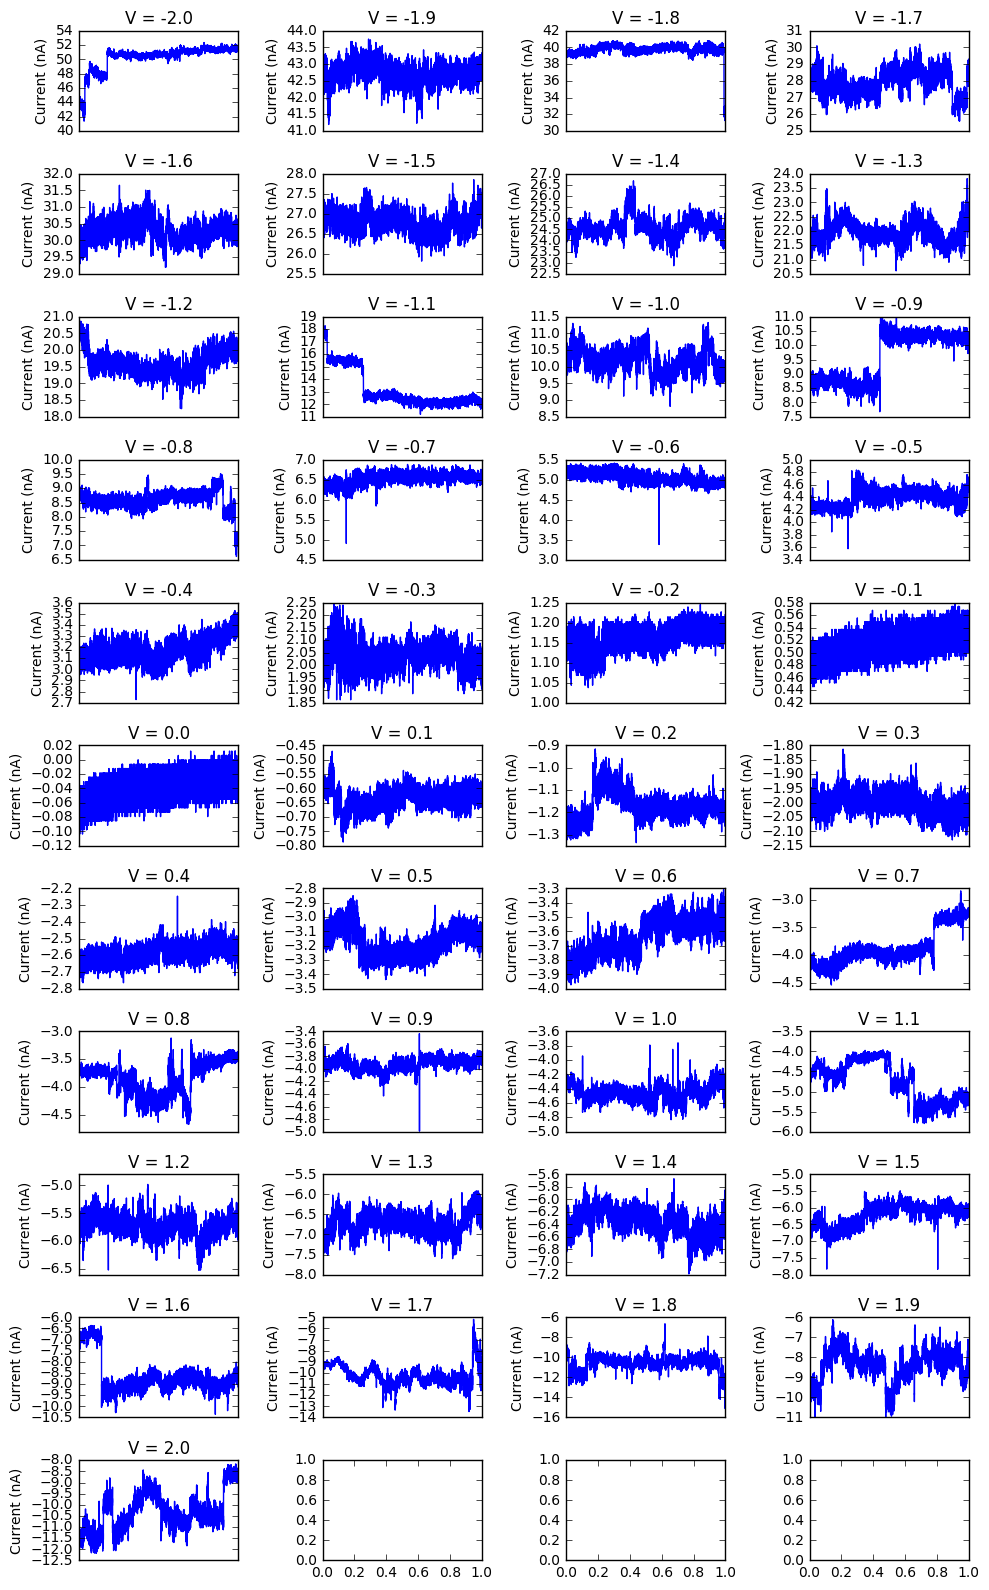

In [4]:

num_columns = 4
num_rows = num_voltages/num_columns + 1


fig, axes = plt.subplots(num_rows, num_columns, figsize = (10,16))
for i in range(num_voltages):
    row = i/4
    column = i%4
    
    plt.sca(axes[row,column])
    plt.plot(data[i,:,0])
    
    # Cosmetics
    plt.title('V = ' + str(voltages[i]))
    plt.ylabel('Current (nA)')
    plt.xticks([])
    
    
fig.tight_layout()
plt.show()

## Gaussian mixture model

#### Fit GMM models with 1 to 7 normal distributions

In [5]:
modelss = []

for i in range(num_voltages):
    
    models = []
    for j in range(1,7):
        
        model = sklearn.mixture.GaussianMixture(n_components=j, covariance_type='full')

        model.fit(data[i,:,0].reshape(-1,1))

        models.append(model)
        
    modelss.append(models)
       

#### Calculate AIC of each model and determine best model

In [6]:
best_models = []
for i in range(num_voltages):
    aics = []
    for j in range(0,6):
        aics.append(modelss[i][j].aic(data[i,:,0].reshape(-1,1)))
        
    best_model_index = np.argmin(aics)
    best_models.append(modelss[i][best_model_index])

## Generate model data

In [7]:
model_data = np.empty((num_voltages, 10000, 2))

for i in range(num_voltages):
    # Get current values
    current_values = np.linspace(data[i,:,0].min(), data[i,:,0].max(), 10000)
    
    # Generate probability of current from model
    predictions = np.exp(best_models[i].score_samples(current_values.reshape(-1,1)))
    
    
    # Append to model data
    model_data[i,:,0] = np.copy(current_values)
    model_data[i,:,1] = np.copy(predictions) 

#### Plot histogram w/ best model

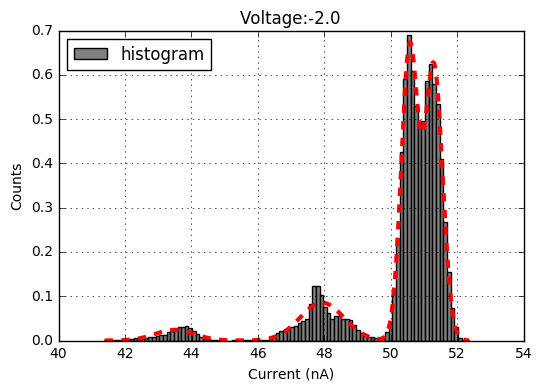

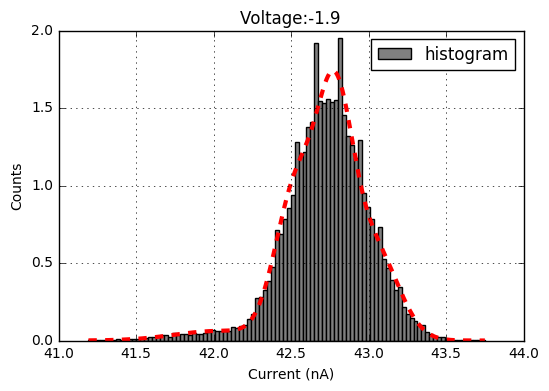

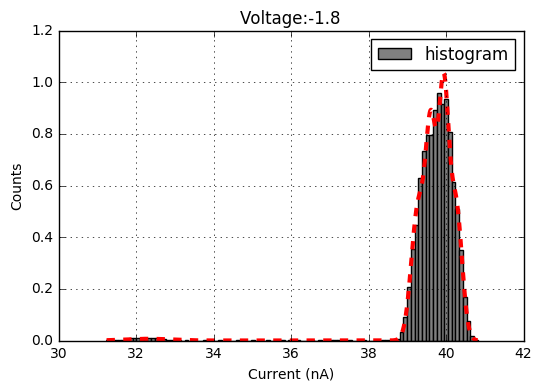

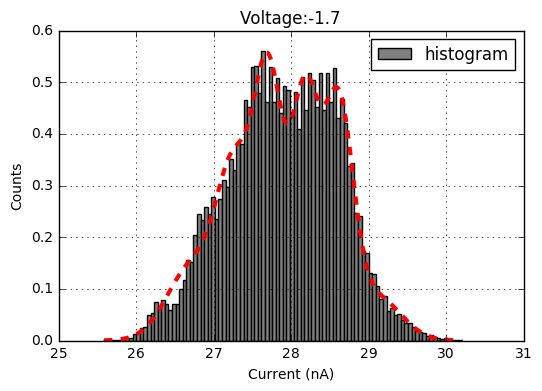

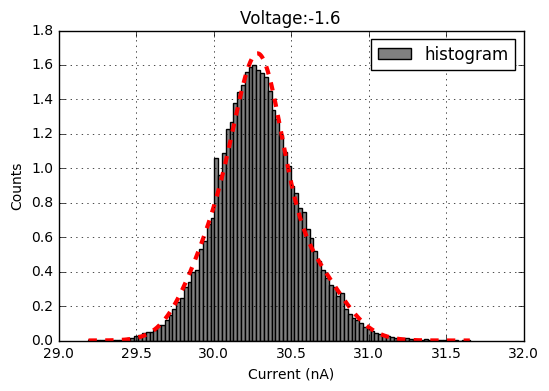

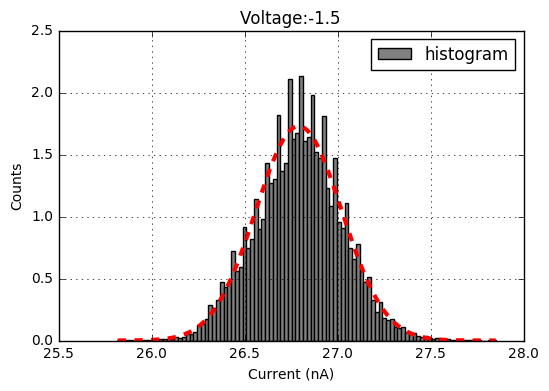

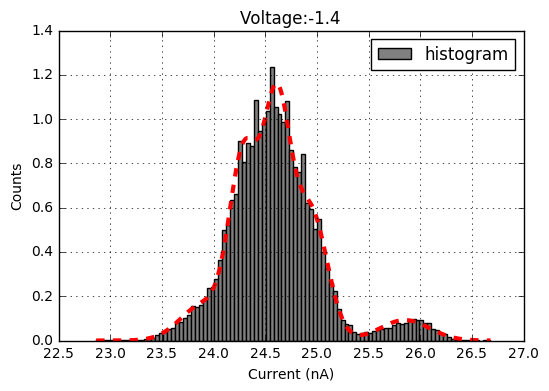

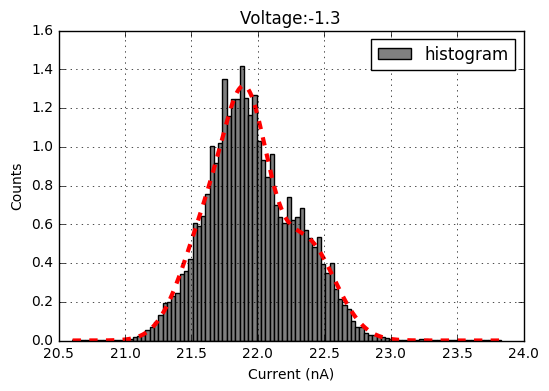

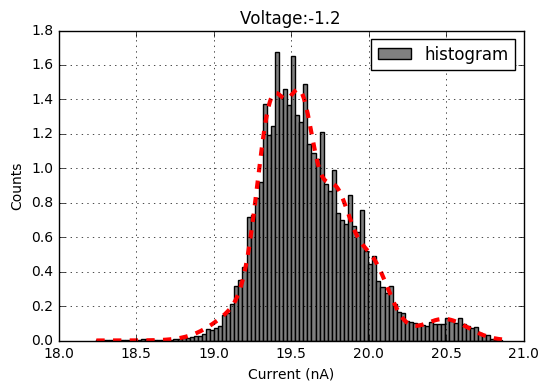

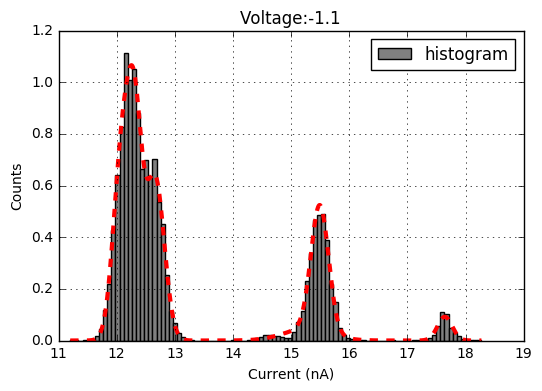

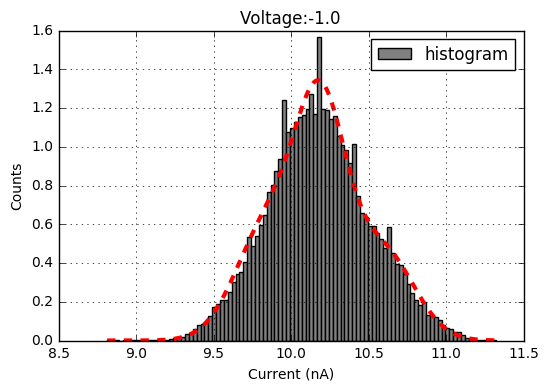

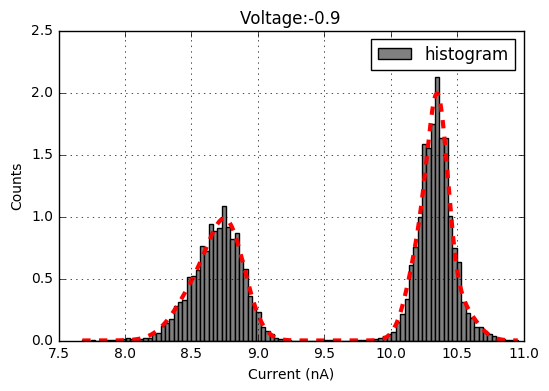

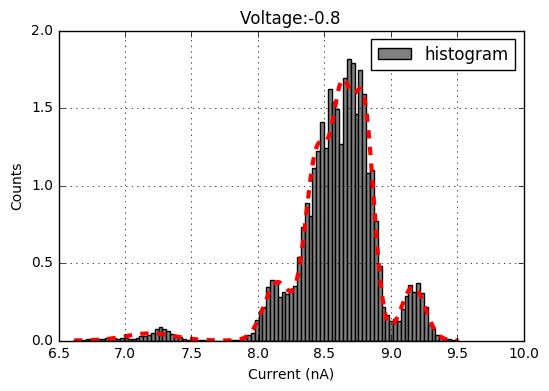

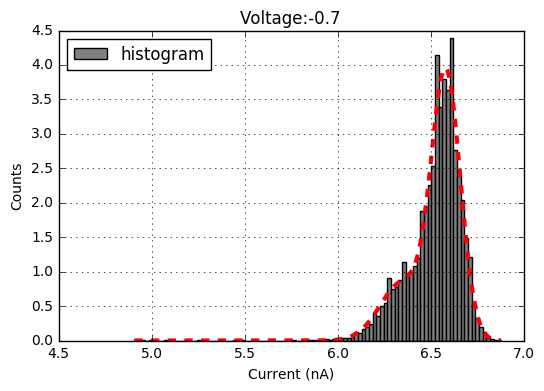

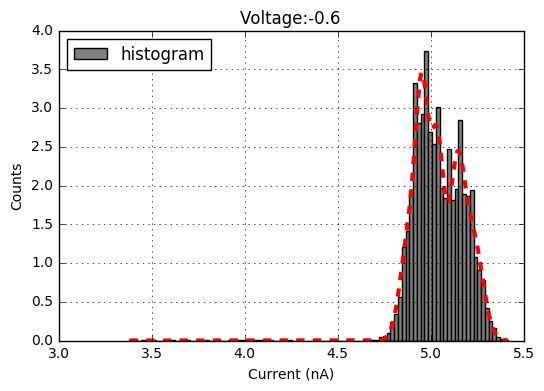

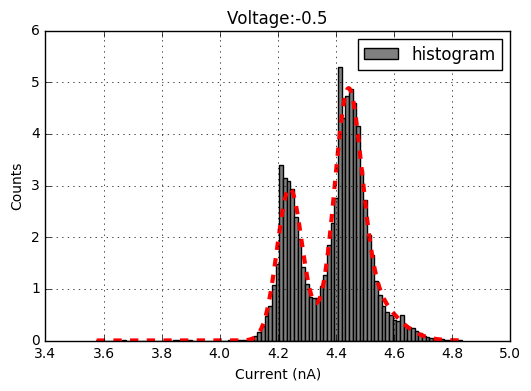

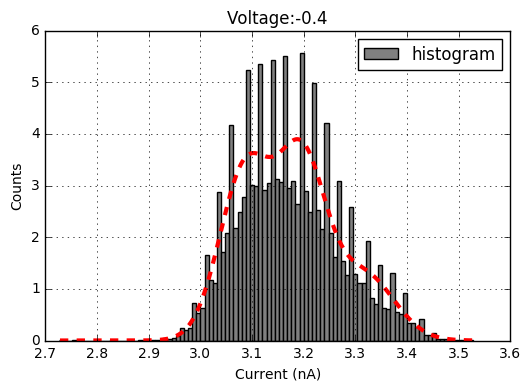

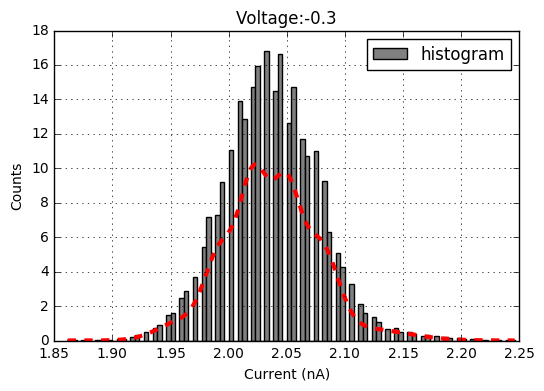

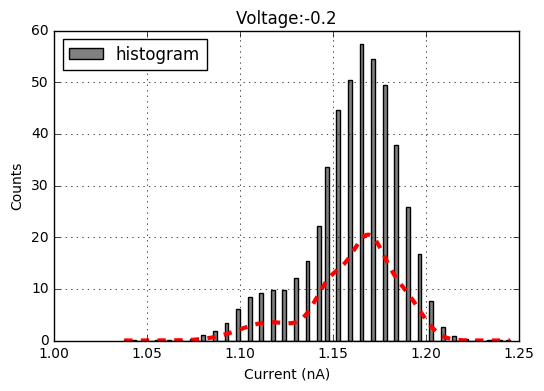

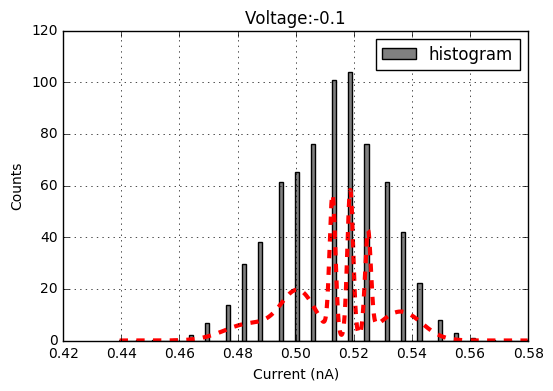

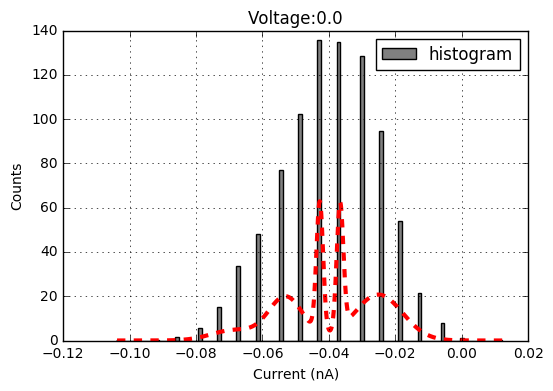

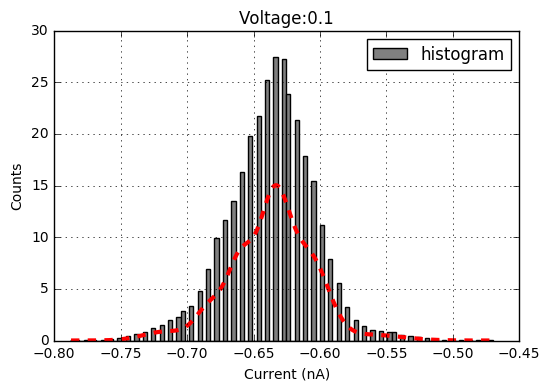

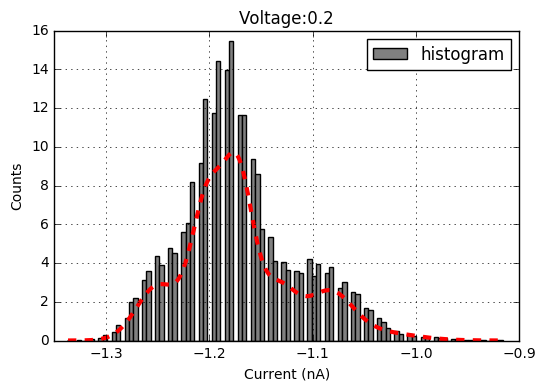

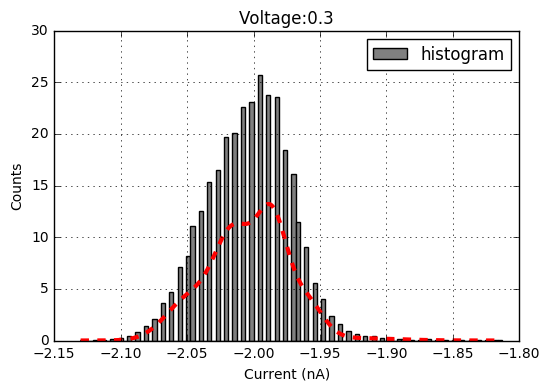

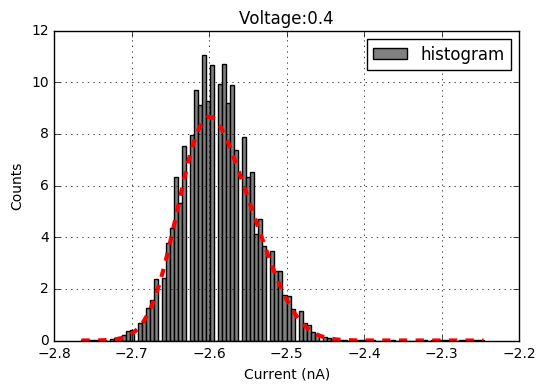

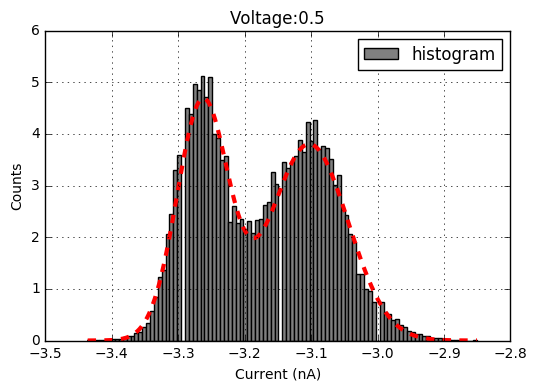

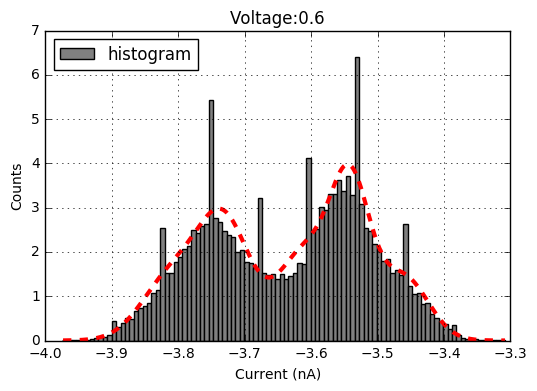

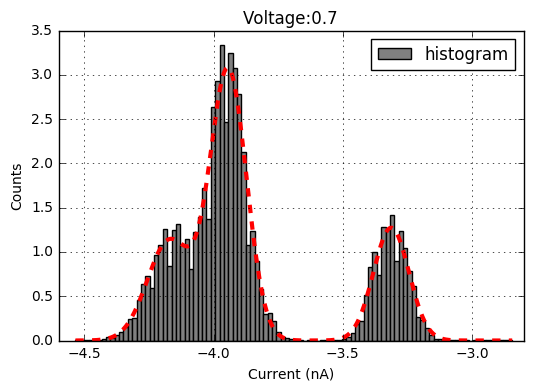

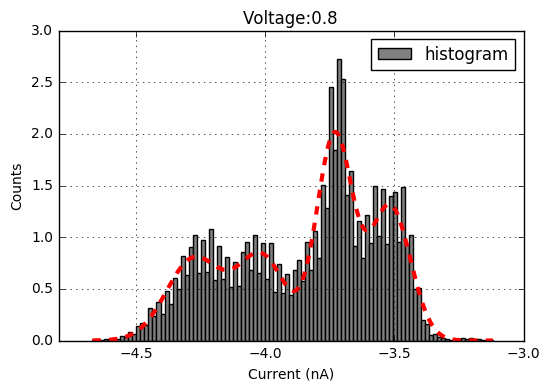

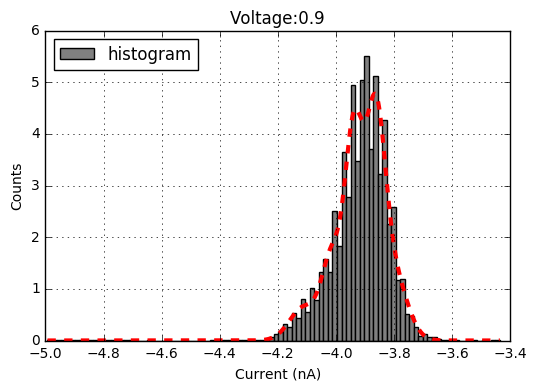

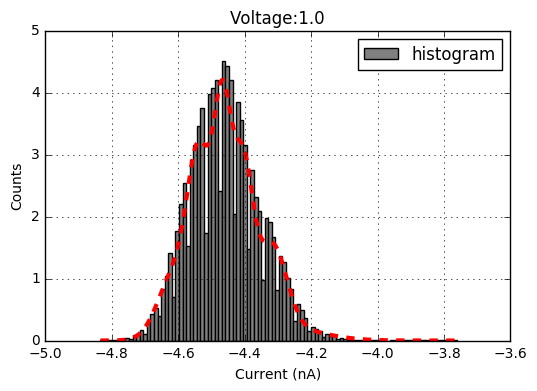

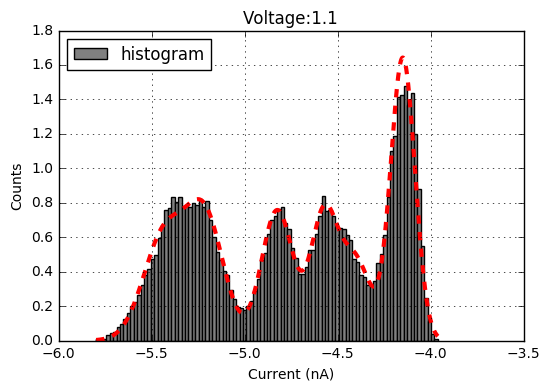

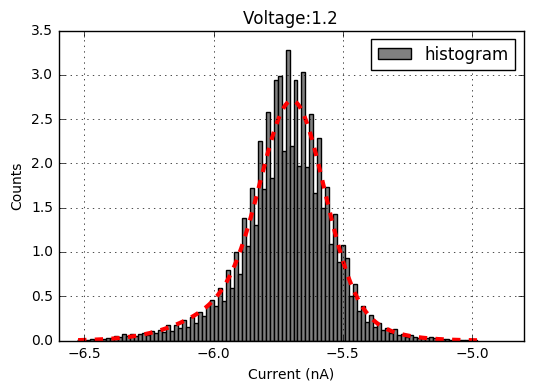

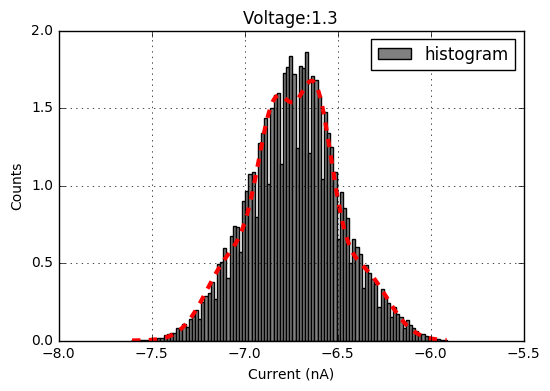

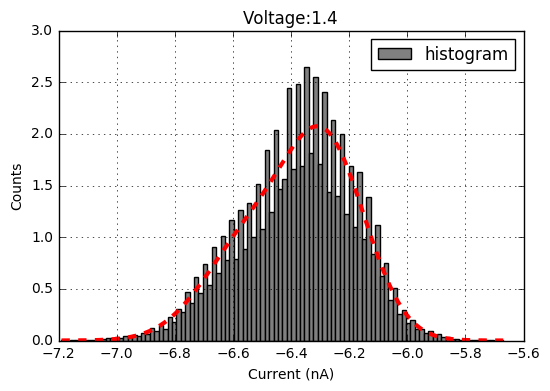

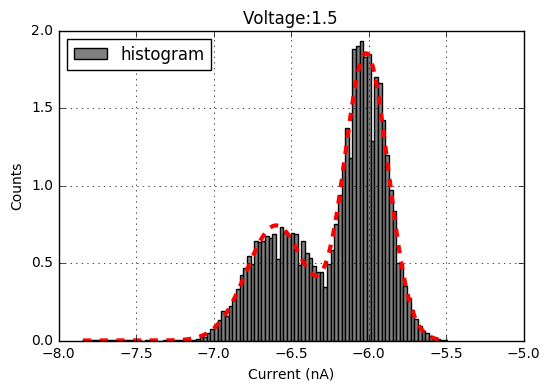

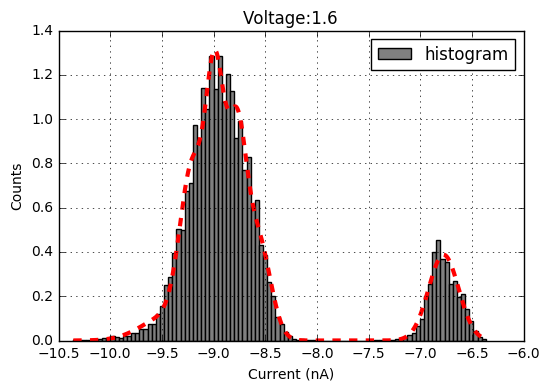

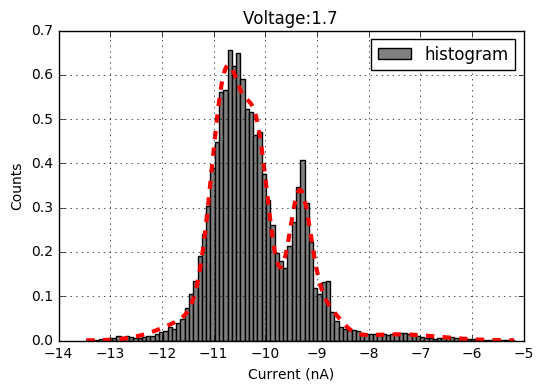

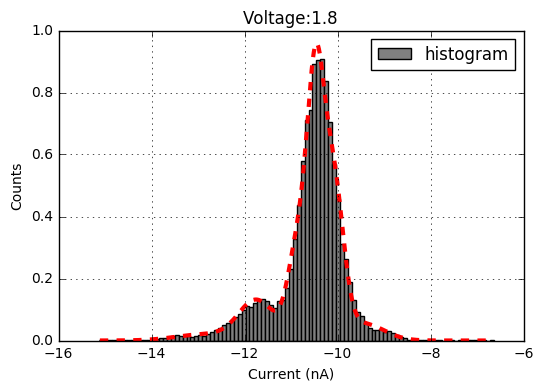

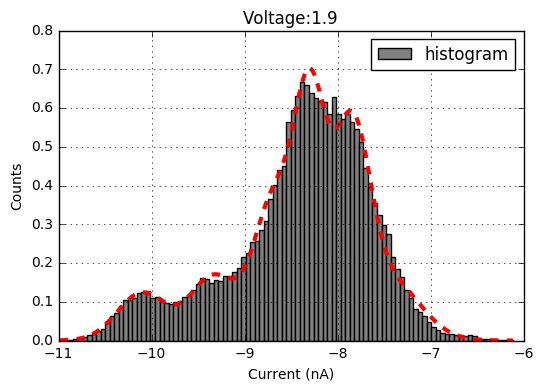

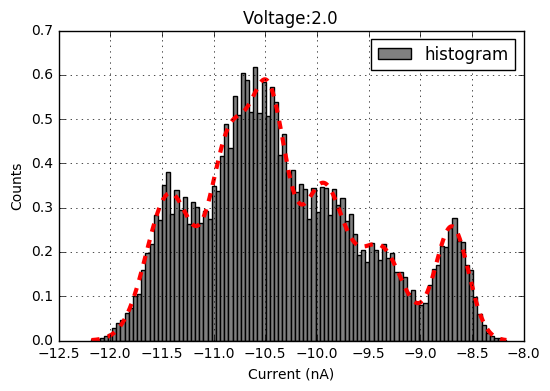

In [8]:
for i in range(num_voltages):
    
    # Histogram
    plt.hist(data[i, :, 0], bins = 100, color = 'gray', label = 'histogram', normed = True)

    # Model fit
    plt.plot(model_data[i,:,0], model_data[i,:,1], lw = 3, color = 'red', ls = '--')
    
    
    # Cosmetics
    plt.title('Voltage:' + str(voltages[i]))
    plt.xlabel('Current (nA)')
    plt.ylabel('Counts')
    plt.grid()
    plt.legend(loc = 'best')
    
    plt.show()
    
    


## Multi-conductance IV

In [9]:
currentss = []
for i in range(num_voltages):
    currents = []
    voltage = voltages[i]

    
    model = best_models[i]
    
    currents = model.means_
    
    currentss.append(currents.flatten())

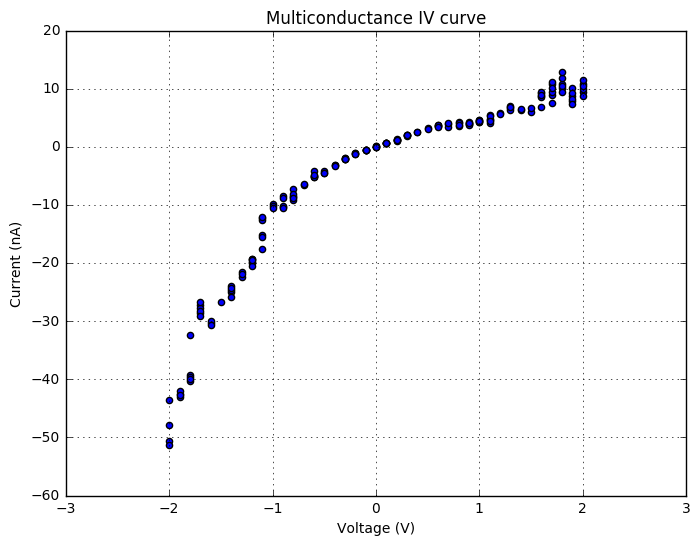

In [11]:
fig = plt.figure(figsize = (8,6))
for i, currents in enumerate(currentss):
    for current in currents:
        plt.scatter(voltages[i], np.array(current)*(-1))
        
        
plt.title('Multiconductance IV curve')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')

plt.grid()        
plt.show()